# CLIP-GPT


---



### Setup Environment

In [1]:
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git
!pip install clip-retrieval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 11.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x_gb44ku
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x_gb44ku
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=28243fa007ce947834f7af24625767601ad59d66688eb53467cf415210f7f9cd
  Sto

In [37]:
import os
import requests
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.optimization import get_linear_schedule_with_warmup

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import skimage.io as io
import matplotlib.pyplot as plt
from IPython.display import Image, display

from pycocotools.coco import COCO
from clip_retrieval.clip_client import ClipClient, Modality

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Fetch Data

Likely want to store these for future reuse.



MS-COCO 2017 Training Captions

In [4]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2023-03-19 22:16:30--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.172.137, 52.217.123.217, 54.231.197.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.172.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  13.2MB/s    in 20s     

2023-03-19 22:16:51 (11.9 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


MS-COCO 2017 Training Images

In [5]:
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip /content/train2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000259556.jpg  
 extracting: train2017/000000381931.jpg  
 extracting: train2017/000000569592.jpg  
 extracting: train2017/000000229396.jpg  
 extracting: train2017/000000488990.jpg  
 extracting: train2017/000000348684.jpg  
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/00

### Create CLIP Embeddings

In [6]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
%%capture
clip_model, preprocess = clip.load("ViT-L/14", device=device) # output dim of 768
clip_model.to(device).eval()

100%|████████████████████████████████████████| 890M/890M [00:04<00:00, 216MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


In [8]:
def batch_encode(image_dir, batch_size=64):
    image_tensors = []

    for i in tqdm(range(0, len(os.listdir(image_dir)), batch_size)):
        images = []

        with torch.no_grad():
            for filename in os.listdir(image_dir)[i:i+batch_size]: 
                images.append(preprocess(Image.open(os.path.join(image_dir, filename))).unsqueeze(0))

            image_tensors.append(clip_model.encode_image(torch.cat(images, dim=0).to(device)).detach().cpu())

    np.save(f"/content/coco_embs/coco_train2017_clip_ViT-L-14_embs.npy", torch.cat(image_tensors, dim=0).numpy(), allow_pickle=True)
    
    return

In [ ]:
batch_encode(image_dir="/content/train2017/", batch_size=512)

In [32]:
with torch.no_grad():
    torch.cuda.empty_cache()

### Load GPT-2 Tokenizer and Model

In [13]:
%%capture
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({"additional_special_tokens": ["[CLIP IN]", "[\CLIP IN]", "[CLIP OUT]", "[\CLIP OUT]"]})

model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
model.resize_token_embeddings(len(tokenizer))
model.eval()

### Setup Data for Training

In [15]:
coco_images = np.load("/content/coco_embs/coco_train2017_clip_ViT-L-14_embs.npy")
coco_images_tensor = torch.Tensor(coco_images)
print(coco_images_tensor.size())

torch.Size([118287, 768])


In [16]:
class COCODataset(Dataset):
    def __init__(self, caption_file, image_dir):
        self.coco_captions = COCO(caption_file)

        self.files = os.listdir(image_dir)
        self.file_id_dict = {}
        self.coco_data = []

        # Create data tuples: (caption, image_id, CLIP embedding, index of embedding)
        for i, f in enumerate(self.files):
            file_id = int(f[:-4])
            self.file_id_dict[i] = file_id
            for ann_id in self.coco_captions.getAnnIds(imgIds=file_id):
                if np.random.random() < 0.5:
                    text = "Caption: [" + self.coco_captions.loadAnns(ids=ann_id)[0]["caption"].strip() + "]. [CLIP OUT][\CLIP OUT]"
                    clip_pos = -1
                else:
                    text = "[CLIP IN] [\CLIP IN] Caption: [" + self.coco_captions.loadAnns(ids=ann_id)[0]["caption"].strip() + "]."
                    clip_pos = 1

                self.coco_data.append((text, 
                self.coco_captions.loadAnns(ids=ann_id)[0]["image_id"],
                coco_images_tensor[i].unsqueeze(0),
                clip_pos))

    def __len__(self):
        return len(self.coco_data)

    def __getitem__(self, idx):
        return self.coco_data[idx]

In [17]:
coco_dataset = COCODataset(caption_file="/content/annotations/captions_train2017.json", image_dir="/content/train2017/")

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!


In [18]:
def collate_fn(batch):
    captions, img_ids, clip_embs, clip_pos = [], [], [], []
    for cap, im_id, emb, p in batch:
        captions.append(cap)
        img_ids.append(im_id)
        clip_embs.append(emb)
        clip_pos.append(p)
    
    clip_embs = torch.cat(clip_embs, dim=0)
    
    return captions, img_ids, clip_embs, clip_pos

sample

('[CLIP IN] [\\CLIP IN] Caption: [A United airliner traveling down the run way.].', 41808)


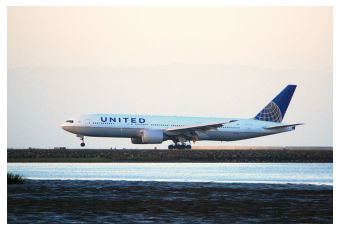

In [20]:
sample_id = 2547
print(coco_dataset.coco_data[sample_id][:2])
I = io.imread(coco_dataset.coco_captions.loadImgs(coco_dataset.coco_data[sample_id][1])[0]['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

### Tune GPT to predict CLIP embeddings from image captions as a continuous output

In [30]:
def train_lm(model, caps, embs, clip_pos):
    # TODO: Optimize training
    
    criterion_ce = torch.nn.CrossEntropyLoss()
    criterion_mse = torch.nn.MSELoss()

    targets = tokenizer(caps, padding=True, return_tensors='pt', return_attention_mask=True)
    targets_ids = targets['input_ids'].to(device)
    targets_mask = targets['attention_mask'].to(device)

    token_embs = model.transformer.wte(targets_ids)

    # Create placeholder tensors to concatenate CLIP embeddings in the case of CLIP->caption
    input_clip_embs = torch.zeros((token_embs.size(0), token_embs.size(1)+1, token_embs.size(2)), device=device)
    target_clip_mask = torch.zeros((targets_mask.size(0), targets_mask.size(1)+1), dtype=torch.int64, device=device)
    target_clip_ids = torch.zeros((targets_ids.size(0), targets_ids.size(1)+1), dtype=torch.int64, device=device)

    embedding_ids = []  # Store indices of caption->CLIP examples
    captioning_ids = [] # Store indices of CLIP->caption examples
    for c in range(len(caps)):
        if clip_pos[c] < 0:
            embedding_ids.append(c)

            tok_count = torch.sum(targets_mask[c])
            pos = tok_count - abs(clip_pos[c])     # position of [\CLIP OUT] token, while ignoring variable padding 

            target_clip_ids[c] = torch.cat((targets_ids[c, :pos+1], torch.full((1,), fill_value=13).to(device), targets_ids[c, pos+1:]), dim=0) # Add period token to match placeholder tensor size
            target_clip_mask[c, :tok_count+1] = 1

            with torch.no_grad():
                input_clip_embs[c] = torch.cat((token_embs[c, :pos+1], model.transformer.wte(torch.tensor([13]).to(device)).reshape(1, -1), token_embs[c, pos+1:]), dim=0)
                
        else:
            captioning_ids.append(c)
            pos = clip_pos[c]        # position of [\CLIP IN] token

            input_clip_embs[c] = torch.cat((token_embs[c, :pos], embs[c].reshape(1, -1).to(device), token_embs[c, pos:]), dim=0) # Add input CLIP embedding
            target_clip_ids[c] = torch.cat((targets_ids[c, :pos], torch.zeros((1,)).to(device), targets_ids[c, pos:]), dim=0)    # Add dummy token; is ignored in loss 
            target_clip_mask[c] = torch.cat((targets_mask[c, :pos], torch.ones((1,)).to(device), targets_mask[c, pos:]), dim=0)  # Avoid masking new token

    outputs = model(
        inputs_embeds=input_clip_embs,
        return_dict=True,
        output_hidden_states=True,
        attention_mask=target_clip_mask
    )

    # Fetch last layer's hidden_state for [\CLIP OUT] tokens
    last_hiddens = []
    for idx in embedding_ids:
        tok_count = torch.sum(targets_mask[idx])                      # Use original position since we concatenated an additional token
        pos = (tok_count - abs(clip_pos[idx])) - 1                    # Subtract 1 since we shift targets
        last_hiddens.append(outputs['hidden_states'][-1][idx][pos])
        
    caption_to_clip_loss = criterion_ce(outputs['logits'][embedding_ids, :-1].view(-1, outputs['logits'].size(-1)), target_clip_ids[embedding_ids, 1:].view(-1)) \
                            + criterion_mse(torch.stack(last_hiddens, dim=0).to(device), embs[embedding_ids].to(device))
    clip_to_caption_loss = torch.nn.functional.cross_entropy(outputs['logits'][captioning_ids, :-1].reshape(-1, outputs['logits'].size(-1)), targets_ids[captioning_ids].flatten(), ignore_index=0)

    loss = caption_to_clip_loss + clip_to_caption_loss

    return loss


def tune_caption_to_CLIP(model, optimizer, scheduler, dataloader, epochs=5):
    
    model.train()
    for epoch in range(epochs):
       
        print(f"Training epoch: {epoch}")
        num_batches = len(dataloader)

        for batch_idx, (caps, _, embs, clip_pos) in  tqdm(enumerate(dataloader)):

            optimizer.zero_grad()

            loss = train_lm(model, caps, embs, clip_pos)
            loss.backward()

            optimizer.step()
            scheduler.step()
            
            if batch_idx % 1000 == 0 and batch_idx != 0:
                print(f"Loss at batch {batch_idx} / {num_batches}  = {loss}")

In [ ]:
coco_dataloader = DataLoader(coco_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=2000, num_training_steps=epochs * len(coco_dataloader))

tune_caption_to_CLIP(model, optimizer, scheduler, coco_dataloader, epochs=epochs)

### Save Model

In [ ]:
model.save_pretrained("/content/pretrained_models/gptLM-coco/")

### Load and KNN

In [ ]:
%%capture

model = GPT2LMHeadModel.from_pretrained("/content/pretrained_models/gptLM-coco/").to(device)
model.eval()

In [ ]:
def log_result(result):
    id, caption, url, similarity = result["id"], result["caption"], result["url"], result["similarity"]
    print(f"id: {id}")
    print(f"caption: {caption}")
    print(f"url: {url}")
    print(f"similarity: {similarity}")
    display(Image(url=url, unconfined=True))
    
    
def nearest_im_neighbors(model, text, neighbors=None, clip_idx=None, k=5):
    model.eval()

    with torch.no_grad():
        outputs = model.generate(**tokenizer(text, return_tensors='pt').to(device), return_dict_in_generate=True, output_hidden_states=True, max_new_tokens=50)
        
        if neighbors is not None:
            print('Number of "neighbors": ', neighbors.shape[0], end="\n\n")

        print("Token ids: ", outputs['sequences'])
        print("Token count: ", len(outputs['sequences'][0]), end="\n\n")

        print("Output text: ", tokenizer.decode(outputs['sequences'][0]))
        print(f"Token at index {clip_idx}: ", tokenizer.decode([outputs['sequences'][0][clip_idx]], skip_special_tokens=False), end="\n\n")

        print("Length of hidden states (number of new tokens): ", len(outputs['hidden_states']))
        print("Number of hidden states: ", len(outputs['hidden_states'][-1]))
        print("Size of a hidden state: ", outputs['hidden_states'][clip_idx][-1].size())

        pred_emb = outputs['hidden_states'][clip_idx][-1][:,-1,:]
        
        if neighbors is not None:
            # 1. Grab learned embedding from last hidden state if last layer for [\CLIP OUT] token
            # 2. Compute embedding similarities with all training embeddings
            # 3. Retrieve top-k similarity image indices
            topk_idx = torch.topk(torch.cosine_similarity(neighbors, pred_emb.cpu().detach(), dim=1), k).indices

            for idx in topk_idx:
                image_id = coco_dataset.file_id_dict[idx.item()]
                I = io.imread(coco_dataset.coco_captions.loadImgs(image_id)[0]['coco_url'])
                plt.axis('off')
                plt.imshow(I)
                plt.show()
        else:
            print("\nFetching most similar image from LAION ...")
            pred_emb /= pred_emb.norm(dim=-1, keepdim=True)
            pred_emb = pred_emb.cpu().detach().numpy().astype("float32")[0]   
            client = ClipClient(url="https://knn.laion.ai/knn-service",
                                indice_name="laion5B-L-14",
                                aesthetic_score=9,
                                aesthetic_weight=0.5,
                                modality=Modality.IMAGE,
                                num_images=10,
                                )
            laion_results = client.query(embedding_input=pred_emb.tolist())
            log_result(laion_results[0])

KNN on COCO

In [ ]:
text = "Caption: [A children's birthday party.]."
nearest_im_neighbors(model, text, coco_images_tensor, clip_idx=-3, k=3)

KNN on LAION-5B

In [ ]:
nearest_im_neighbors(model, text, clip_idx=-3, k=3)

### Generate caption from image CLIP embedding

In [ ]:
# From https://github.com/rmokady/CLIP_prefix_caption/blob/main/predict.py
def greedy_generate(
    model,
    tokenizer,
    tokens=None,
    prompt=None,
    embed=None,
    entry_count=1,
    entry_length=67,  # maximum number of words
    top_p=0.8,
    temperature=1.0,
    stop_token: str = ".",
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.transformer.wte(tokens)

            for i in range(entry_length):
                generated = generated.to(device)
                outputs = model(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(
                    torch.nn.functional.softmax(sorted_logits, dim=-1), dim=-1
                )
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

Original caption within modified text: [CLIP IN] [\CLIP IN] Caption: [A stove top is cleaned with a set of knives on the wall.].


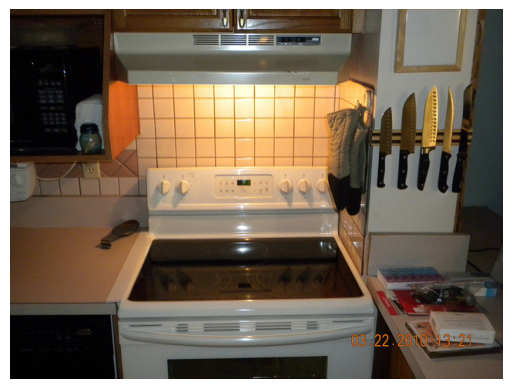

Generate text from input image CLIP embedding:


'[\\CLIP IN] Caption: [A stove with a microwave above it and a toaster oven.].<|endoftext|>'

In [ ]:
test_id = 89

print("Original caption within modified text:", coco_dataset.coco_data[test_id][0])

I = io.imread(coco_dataset.coco_captions.loadImgs(coco_dataset.coco_data[test_id][1])[0]['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

print("Generate text from input image CLIP embedding:")
greedy_generate(model, tokenizer, embed=coco_dataset.coco_data[test_id][2].reshape(1, 1, -1), stop_token=tokenizer.pad_token)